In [1]:
import os
import glob
from os.path import join
import json
import csv

from pandas import read_csv, DataFrame, MultiIndex
from vega import VegaLite
from qiime2 import Artifact
from numpy import average

In [2]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [3]:
abundances_file = open(join(empo3_dir, 'abundances.tsv'), 'w')
abundances = csv.writer(abundances_file, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
abundances.writerow(['sample type', 'sample', 'abundance'])
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'shannon.json')):
        continue
    type_ = os.path.basename(type_dir)
    for artifact_file in glob.glob(join(empo3_dir, type_, 'results', 'abundance', '*')):
        df = Artifact.load(artifact_file).view(DataFrame)
        sample = os.path.basename(artifact_file)[:-4]
        abundances.writerow([type_, sample, int(df.sum(axis=1)['Frequency'])])
    abundances_file.flush()
abundances_file.close()

In [3]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [4]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
#prf = prf[(prf['level'] == 7) & (prf['method'] == 'weighted')]
#prf = prf[(prf['class weights'] == 'bespoke70') | (prf['class weights'] == 'uniform70')]
prf = prf[(((prf['level'] == 7) & (prf['class weights'] == 'bespoke70')) |
           ((prf['level'] == 7) & (prf['class weights'] == 'uniform70'))) & 
          (prf['method'] == 'weighted')]
prf = prf.join(abundances, ['sample type', 'sample'])
type_totals = prf.groupby(['sample type', 'class weights'])['abundance'].sum()
type_totals = DataFrame(type_totals.xs('bespoke70', level='class weights'))
type_totals.columns=['type abundance']
prf = prf.join(type_totals, ['sample type'])
prf['type weight'] = prf.apply(lambda r: r['abundance']/r['type abundance'], axis=1)
weighted_f_measure = prf.groupby(['sample type', 'class weights'])
weighted_f_measure = DataFrame(weighted_f_measure.apply(
    lambda x: average(x['F-measure'], weights=x['type weight'])))
weighted_f_measure.columns = ['F-measure']

In [5]:
weighted_f_measure

F-measure
sample type         class weights           
animal-corpus       bespoke70       0.866545
                    uniform70       0.760571
animal-distal-gut   bespoke70       0.865278
                    uniform70       0.805500
animal-proximal-gut bespoke70       0.828570
                    uniform70       0.719415
animal-secretion    bespoke70       0.893592
                    uniform70       0.731040
animal-surface      bespoke70       0.880874
                    uniform70       0.755215
mock-community      bespoke70       0.807225
                    uniform70       0.730104
plant-corpus        bespoke70       0.932086
                    uniform70       0.903317
plant-rhizosphere   bespoke70       0.923714
                    uniform70       0.889836
plant-surface       bespoke70       0.887587
                    uniform70       0.869712
sediment-non-saline bespoke70       0.901827
                    uniform70       0.874117
sediment-saline     bespoke70       0.902191
                    uniform70       0.868830
single-strain       bespoke70       0.981387
                    uniform70       0.303110
soil-non-saline     bespoke70       0.895367
                    uniform70       0.848506
sterile-water-blank bespoke70       0.839275
                    uniform70       0.728669
surface-non-saline  bespoke70       0.894722
                    uniform70       0.727588
surface-saline      bespoke70       0.850893
                    uniform70       0.788724
water-non-saline    bespoke70       0.910821
                    uniform70       0.864683
water-saline        bespoke70       0.871432
                    uniform70       0.814898

In [7]:
columns = ('type', 'n', 'h', 'weighted_h', 'jsd', 'weighted_jsd',
           'F-measure')
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'shannon.json')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick'):
        continue
    data['type'].append(type_)
    with open(join(type_dir, 'results', 'shannon.json')) as shannon_file:
        shannon = json.load(shannon_file)
    for k, v in shannon.items():
        data[k].append(v)
    for column in columns[-1:]:
        data[column].append(
            weighted_f_measure[column][type_]['bespoke70'] -
            weighted_f_measure[column][type_]['uniform70'])
shannon = DataFrame(data)

In [8]:
shannon

,F-measure,h,jsd,n,type,weighted_h,weighted_jsd
0,0.046138,4.703695,1.678253,4769,water-non-saline,4.793743,1.501802
1,0.105974,4.915176,2.677689,1158,animal-corpus,5.022477,2.579882
2,0.033878,4.956982,0.614809,328,plant-rhizosphere,4.673926,0.519836
3,0.046862,5.434253,1.257307,2802,soil-non-saline,5.296395,1.000072
4,0.033361,5.121340,1.373665,414,sediment-saline,5.196716,1.325386
5,0.162551,4.007422,1.607815,974,animal-secretion,4.552654,1.886562
6,0.125659,4.672874,1.802770,1839,animal-surface,4.839412,1.926257
7,0.017874,3.823037,0.806619,8,plant-surface,3.394275,0.323635
8,0.028769,3.727922,1.928080,543,plant-corpus,1.768856,1.065912
9,0.059778,4.844128,2.255175,5632,animal-distal-gut,4.242186,1.945954


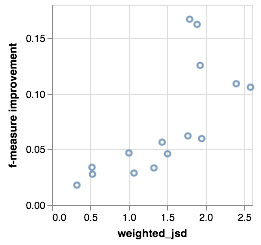

In [11]:
VegaLite({
  "mark": "point",
  "encoding": {
    "x": {"type": "quantitative", "field": "weighted_jsd"},
    "y": {"type": "quantitative", "field": "F-measure", "axis": {"title": "f-measure improvement"}},
    "tooltip": [
        {"type": "quantitative", "field": "h"},
        {"type": "quantitative", "field": "n"},
        {"type": "quantitative", "field": "F-measure"},
        {"type": "ordinal", "field": "type"}
    ]
  }
}, shannon)